In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import dask.dataframe as dd
import warnings
from numba import jit, njit,prange
import psutil
import ast

In [ ]:
# 경고 무시 설정
warnings.simplefilter(action='ignore', category=FutureWarning)

# 데이터 타입 명시
dtypes = {
    'open': 'float32',
    'high': 'float32',
    'low': 'float32',
    'close': 'float32',
    'volume': 'float32',
    'RSI_10': 'float32',
    'RSI_20': 'float32',
    'RSI_30': 'float32',
    'RSI_40': 'float32',
    'RSI_50': 'float32',
    'RSI_60': 'float32',
    'MACD_Line': 'float32',
    'MACD_Signal': 'float32',
    'MACD_Histogram': 'float32',
    'CCI_5': 'float32',
    'CCI_10': 'float32',
    'CCI_20': 'float32',
    'MFI_10': 'float32',
    'MFI_20': 'float32',
    'MFI_30': 'float32',
    'MFI_40': 'float32',
    'MFI_50': 'float32',
    'MFI_60': 'float32',
    'Volume_Ratio_10': 'float32',
    'Volume_Ratio_20': 'float32',
    'Volume_Ratio_30': 'float32',
    'Volume_Ratio_40': 'float32',
    'Volume_Ratio_50': 'float32',
    'Volume_Ratio_60': 'float32',
    'TR': 'float32',
    'ATR': 'float32',
    'Basic Upper Band': 'float32',
    'Basic Lower Band': 'float32',
    'Final Upper Band': 'float32',
    'Final Lower Band': 'float32',
    'SuperTrend': 'float32',
    'VWAP': 'float32',
    'INDICATOR': 'float32',
    'high_ind': 'float32',
    'low_ind': 'float32',
    'diff': 'float32'
}

# Load the dataset from Kaggle
file_path = '/content/drive/MyDrive/Data/SOL60_Indicator.csv'
#file_path = '/content/SOL60_Indicator.csv'

# Dask를 사용하여 CSV 파일 읽기
dask_df = dd.read_csv(file_path, dtype=dtypes, parse_dates=['open_time'])

# Dask 데이터프레임을 pandas 데이터프레임으로 변환
data = dask_df.compute()

# Display the first few rows of the dataset to ensure it is loaded correctly
data.head()

,open_time,open,high,low,close,volume,RSI_10,RSI_20,RSI_30,RSI_40,...,Basic Upper Band,Basic Lower Band,Final Upper Band,Final Lower Band,SuperTrend,VWAP,INDICATOR,high_ind,low_ind,diff
0,2020-12-31 15:00:00,1.4458,1.4458,1.4444,1.4456,161.339996,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,1.445267,NaN,NaN,NaN,NaN
1,2020-12-31 15:01:00,1.4477,1.4478,1.4463,1.4463,148.860001,100.0,100.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,1.446002,NaN,NaN,NaN,NaN
2,2020-12-31 15:02:00,1.4479,1.4530,1.4466,1.4484,3208.129883,100.0,100.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,1.449040,NaN,NaN,NaN,NaN
3,2020-12-31 15:03:00,1.4503,1.4559,1.4503,1.4558,1639.760010,100.0,100.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,1.450617,NaN,NaN,NaN,NaN
4,2020-12-31 15:04:00,1.4558,1.4569,1.4545,1.4569,900.909973,100.0,100.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,1.451432,NaN,NaN,NaN,NaN


In [ ]:
columns_list = data.columns.tolist()
columns_list

['open_time',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'RSI_10',
 'RSI_20',
 'RSI_30',
 'RSI_40',
 'RSI_50',
 'RSI_60',
 'MACD_Line',
 'MACD_Signal',
 'MACD_Histogram',
 'CCI_5',
 'CCI_10',
 'CCI_20',
 'MFI_10',
 'MFI_20',
 'MFI_30',
 'MFI_40',
 'MFI_50',
 'MFI_60',
 'Volume_Ratio_10',
 'Volume_Ratio_20',
 'Volume_Ratio_30',
 'Volume_Ratio_40',
 'Volume_Ratio_50',
 'Volume_Ratio_60',
 'TR',
 'ATR',
 'Basic Upper Band',
 'Basic Lower Band',
 'Final Upper Band',
 'Final Lower Band',
 'SuperTrend',
 'VWAP',
 'INDICATOR',
 'high_ind',
 'low_ind',
 'diff']

In [ ]:
len(data)

1856536

In [ ]:
@njit
def fast_percentage_change(start, end):
    return ((end - start) / start) * 100

@njit(parallel=True)
def process_data(data, num_features):
    total_length = len(data)
    results = np.empty((total_length, 9 + 3 * num_features), dtype=np.float64)

    for i in prange(total_length):
        start_time = data[i, 0]
        end_time = start_time + 3600  # 60분(1시간) 동안의 초

        subset_indices = np.where((data[:, 0] >= start_time) & (data[:, 0] <= end_time))[0]
        if len(subset_indices) == 0:
            results[i, :] = np.nan
            continue

        subset = data[subset_indices]
        start_close = data[i, 4]

        highest_idx = np.argmax(subset[:, 2])
        lowest_idx = np.argmin(subset[:, 3])

        highest_row = subset[highest_idx]
        lowest_row = subset[lowest_idx]

        highest_change = fast_percentage_change(start_close, highest_row[2])
        lowest_change = fast_percentage_change(start_close, lowest_row[3])

        results[i, 0] = start_time
        results[i, 1] = end_time
        results[i, 2] = data[i, 5]
        results[i, 3] = highest_row[0]
        results[i, 4] = highest_change
        results[i, 5] = highest_row[5]
        results[i, 6] = lowest_row[0]
        results[i, 7] = lowest_change
        results[i, 8] = lowest_row[5]

        start_indicators = data[i, 6:]
        highest_indicators = highest_row[6:]
        lowest_indicators = lowest_row[6:]

        results[i, 9:9 + num_features] = start_indicators  # 시작 지표
        results[i, 9 + num_features:9 + 2 * num_features] = highest_indicators  # 최고 상승 지표
        results[i, 9 + 2 * num_features:] = lowest_indicators  # 최대 하락 지표

    return results

def memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    return mem_info.rss / 1024 ** 2  # MB 단위로 변환

# 데이터 준비
data['open_time'] = pd.to_datetime(data['open_time']).astype(np.int64) // 10**9
data_array = data.to_numpy()
total_length = len(data_array)

# 메모리 사용량 확인
initial_memory_usage = memory_usage()
print(f'Initial memory usage: {initial_memory_usage:.2f} MB')

# 데이터 처리
num_features = data_array.shape[1] - 6

# tqdm을 사용하여 진행 상황 표시
results = np.empty((total_length, 9 + 3 * num_features), dtype=np.float64)

# 데이터 처리 및 진행 상황 표시
for i in tqdm(range(total_length), desc="Processing", ncols=100):
    start_time = data_array[i, 0]
    end_time = start_time + 3600  # 60분(1시간) 동안의 초

    subset_mask = (data_array[:, 0] >= start_time) & (data_array[:, 0] <= end_time)
    subset_indices = np.where(subset_mask)[0]

    if len(subset_indices) == 0:
        results[i, :] = np.nan
        continue

    subset = data_array[subset_indices]
    start_close = data_array[i, 4]

    highest_idx = np.argmax(subset[:, 2])
    lowest_idx = np.argmin(subset[:, 3])

    highest_row = subset[highest_idx]
    lowest_row = subset[lowest_idx]

    highest_change = fast_percentage_change(start_close, highest_row[2])
    lowest_change = fast_percentage_change(start_close, lowest_row[3])

    results[i, 0] = start_time
    results[i, 1] = end_time
    results[i, 2] = data_array[i, 5]
    results[i, 3] = highest_row[0]
    results[i, 4] = highest_change
    results[i, 5] = highest_row[5]
    results[i, 6] = lowest_row[0]
    results[i, 7] = lowest_change
    results[i, 8] = lowest_row[5]

    start_indicators = data_array[i, 6:]
    highest_indicators = highest_row[6:]
    lowest_indicators = lowest_row[6:]

    results[i, 9:9 + num_features] = start_indicators  # 시작 지표
    results[i, 9 + num_features:9 + 2 * num_features] = highest_indicators  # 최고 상승 지표
    results[i, 9 + 2 * num_features:] = lowest_indicators  # 최대 하락 지표

# 결과를 DataFrame으로 변환
start_indicator_columns = [f'start_indicator_{i}' for i in range(num_features)]
highest_indicator_columns = [f'highest_indicator_{i}' for i in range(num_features)]
lowest_indicator_columns = [f'lowest_indicator_{i}' for i in range(num_features)]

column_names = [
    'start_time', 'end_time', 'volume_at_start',
    'highest_time', 'highest_change', 'highest_volume',
    'lowest_time', 'lowest_change', 'lowest_volume'
] + start_indicator_columns + highest_indicator_columns + lowest_indicator_columns

result_df = pd.DataFrame(results, columns=column_names).drop_duplicates().reset_index(drop=True)

# Unix 타임스탬프 열을 datetime으로 다시 변환
for col in ['start_time', 'end_time', 'highest_time', 'lowest_time']:
    result_df[col] = pd.to_datetime(result_df[col], unit='s')

# 메모리 사용량 확인
final_memory_usage = memory_usage()
print(f'Final memory usage: {final_memory_usage:.2f} MB')

Initial memory usage: 1266.71 MB


Processing: 100%|██████████████████████████████████████| 1856536/1856536 [2:13:18<00:00, 232.11it/s]


Final memory usage: 4655.08 MB


In [ ]:
#1시간씩 간격을 나누어서 종가 기준으로 최대 상승 및 하락하는 %를 구하는

@njit
def fast_percentage_change(start, end):
    return ((end - start) / start) * 100

@njit(parallel=True)
def process_data(data, num_features):
    total_length = len(data)
    results = np.empty((total_length, 9 + 3 * num_features), dtype=np.float64)

    for i in prange(total_length):
        start_time = data[i, 0]
        end_time = start_time + 3600  # 60분(1시간) 동안의 초

        subset_mask = (data[:, 0] >= start_time) & (data[:, 0] <= end_time)
        subset = data[subset_mask]

        if len(subset) == 0:
            results[i, :] = np.nan
            continue

        start_close = data[i, 4]

        highest_idx = np.argmax(subset[:, 2])
        lowest_idx = np.argmin(subset[:, 3])

        highest_row = subset[highest_idx]
        lowest_row = subset[lowest_idx]

        highest_change = fast_percentage_change(start_close, highest_row[2])
        lowest_change = fast_percentage_change(start_close, lowest_row[3])

        results[i, 0] = start_time
        results[i, 1] = end_time
        results[i, 2] = data[i, 5]
        results[i, 3] = highest_row[0]
        results[i, 4] = highest_change
        results[i, 5] = highest_row[5]
        results[i, 6] = lowest_row[0]
        results[i, 7] = lowest_change
        results[i, 8] = lowest_row[5]

        start_indicators = data[i, 6:]
        highest_indicators = highest_row[6:]
        lowest_indicators = lowest_row[6:]

        results[i, 9:9 + num_features] = start_indicators  # 시작 지표
        results[i, 9 + num_features:9 + 2 * num_features] = highest_indicators  # 최고 상승 지표
        results[i, 9 + 2 * num_features:] = lowest_indicators  # 최대 하락 지표

    return results

def memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    return mem_info.rss / 1024 ** 2  # MB 단위로 변환

# 데이터 준비
data['open_time'] = pd.to_datetime(data['open_time']).astype(np.int64) // 10**9
data_array = data.to_numpy()

# 메모리 사용량 확인
initial_memory_usage = memory_usage()
print(f'Initial memory usage: {initial_memory_usage:.2f} MB')

# 데이터 처리
num_features = data_array.shape[1] - 6

# tqdm을 사용하여 진행 상황 표시
results = np.empty((len(data_array), 9 + 3 * num_features), dtype=np.float64)

# 데이터 처리 및 진행 상황 표시
for i in tqdm(prange(len(data_array)), desc="Processing", ncols=100):
    start_time = data_array[i, 0]
    end_time = start_time + 3600  # 60분(1시간) 동안의 초

    subset_mask = (data_array[:, 0] >= start_time) & (data_array[:, 0] <= end_time)
    subset_indices = np.where(subset_mask)[0]

    if len(subset_indices) == 0:
        results[i, :] = np.nan
        continue

    subset = data_array[subset_indices]
    start_close = data_array[i, 4]

    highest_idx = np.argmax(subset[:, 2])
    lowest_idx = np.argmin(subset[:, 3])

    highest_row = subset[highest_idx]
    lowest_row = subset[lowest_idx]

    highest_change = fast_percentage_change(start_close, highest_row[2])
    lowest_change = fast_percentage_change(start_close, lowest_row[3])

    results[i, 0] = start_time
    results[i, 1] = end_time
    results[i, 2] = data_array[i, 5]
    results[i, 3] = highest_row[0]
    results[i, 4] = highest_change
    results[i, 5] = highest_row[5]
    results[i, 6] = lowest_row[0]
    results[i, 7] = lowest_change
    results[i, 8] = lowest_row[5]

    start_indicators = data_array[i, 6:]
    highest_indicators = highest_row[6:]
    lowest_indicators = lowest_row[6:]

    results[i, 9:9 + num_features] = start_indicators  # 시작 지표
    results[i, 9 + num_features:9 + 2 * num_features] = highest_indicators  # 최고 상승 지표
    results[i, 9 + 2 * num_features:] = lowest_indicators  # 최대 하락 지표

# 결과를 DataFrame으로 변환
start_indicator_columns = [f'start_indicator_{i}' for i in range(num_features)]
highest_indicator_columns = [f'highest_indicator_{i}' for i in range(num_features)]
lowest_indicator_columns = [f'lowest_indicator_{i}' for i in range(num_features)]

column_names = [
    'start_time', 'end_time', 'volume_at_start',
    'highest_time', 'highest_change', 'highest_volume',
    'lowest_time', 'lowest_change', 'lowest_volume'
] + start_indicator_columns + highest_indicator_columns + lowest_indicator_columns

result_df = pd.DataFrame(results, columns=column_names).drop_duplicates().reset_index(drop=True)

# Unix 타임스탬프 열을 datetime으로 다시 변환
for col in ['start_time', 'end_time', 'highest_time', 'lowest_time']:
    result_df[col] = pd.to_datetime(result_df[col], unit='s')

# 메모리 사용량 확인
final_memory_usage = memory_usage()
print(f'Final memory usage: {final_memory_usage:.2f} MB')

Initial memory usage: 1279.45 MB


Processing:   1%|▍                                       | 19119/1856536 [01:15<1:53:26, 269.94it/s]

In [ ]:
result_df.head()

,start_time,end_time,volume_at_start,highest_time,highest_change,highest_volume,lowest_time,lowest_change,lowest_volume,start_indicator_0,...,lowest_indicator_26,lowest_indicator_27,lowest_indicator_28,lowest_indicator_29,lowest_indicator_30,lowest_indicator_31,lowest_indicator_32,lowest_indicator_33,lowest_indicator_34,lowest_indicator_35
0,2020-12-31 15:00:00,2020-12-31 16:00:00,161.339996,2020-12-31 16:00:00,1.203654,4054.419922,2020-12-31 15:16:00,-0.387381,2194.629883,NaN,...,1.45448,1.42952,1.45448,1.43905,1.45448,1.449645,28.085106,NaN,NaN,NaN
1,2020-12-31 15:01:00,2020-12-31 16:01:00,148.860001,2020-12-31 16:00:00,1.154673,4054.419922,2020-12-31 15:16:00,-0.435592,2194.629883,100.0,...,1.45448,1.42952,1.45448,1.43905,1.45448,1.449645,28.085106,NaN,NaN,NaN
2,2020-12-31 15:02:00,2020-12-31 16:02:00,3208.129883,2020-12-31 16:00:00,1.008011,4054.419922,2020-12-31 15:16:00,-0.579948,2194.629883,100.0,...,1.45448,1.42952,1.45448,1.43905,1.45448,1.449645,28.085106,NaN,NaN,NaN
3,2020-12-31 15:03:00,2020-12-31 16:03:00,1639.760010,2020-12-31 16:00:00,0.494574,4054.419922,2020-12-31 15:16:00,-1.085314,2194.629883,100.0,...,1.45448,1.42952,1.45448,1.43905,1.45448,1.449645,28.085106,NaN,NaN,NaN
4,2020-12-31 15:04:00,2020-12-31 16:04:00,900.909973,2020-12-31 16:00:00,0.418701,4054.419922,2020-12-31 15:16:00,-1.159993,2194.629883,100.0,...,1.45448,1.42952,1.45448,1.43905,1.45448,1.449645,28.085106,NaN,NaN,NaN


In [ ]:
len(result_df)

1856536

In [ ]:
# 저장할 경로 설정
save_path1 = '/content/drive/MyDrive/Data/SOL60_Indicator_rise_fall_percentages.csv'

# CSV 파일로 저장
result_df.to_csv(save_path1, index=False)

NameError: name 'result_df' is not defined

In [2]:
file_path2 = '/content/drive/MyDrive/Data/SOL60_Indicator_rise_fall_percentages.csv'
data2 = pd.read_csv(file_path2)

In [3]:
columns_list2 = data2.columns.tolist()
columns_list2

['start_time',
 'end_time',
 'volume_at_start',
 'highest_time',
 'highest_change',
 'highest_volume',
 'lowest_time',
 'lowest_change',
 'lowest_volume',
 'start_indicator_0',
 'start_indicator_1',
 'start_indicator_2',
 'start_indicator_3',
 'start_indicator_4',
 'start_indicator_5',
 'start_indicator_6',
 'start_indicator_7',
 'start_indicator_8',
 'start_indicator_9',
 'start_indicator_10',
 'start_indicator_11',
 'start_indicator_12',
 'start_indicator_13',
 'start_indicator_14',
 'start_indicator_15',
 'start_indicator_16',
 'start_indicator_17',
 'start_indicator_18',
 'start_indicator_19',
 'start_indicator_20',
 'start_indicator_21',
 'start_indicator_22',
 'start_indicator_23',
 'start_indicator_24',
 'start_indicator_25',
 'start_indicator_26',
 'start_indicator_27',
 'start_indicator_28',
 'start_indicator_29',
 'start_indicator_30',
 'start_indicator_31',
 'start_indicator_32',
 'start_indicator_33',
 'start_indicator_34',
 'start_indicator_35',
 'highest_indicator_0',
 'h

In [4]:
data2.tail()

,start_time,end_time,volume_at_start,highest_time,highest_change,highest_volume,lowest_time,lowest_change,lowest_volume,start_indicator_0,...,lowest_indicator_26,lowest_indicator_27,lowest_indicator_28,lowest_indicator_29,lowest_indicator_30,lowest_indicator_31,lowest_indicator_32,lowest_indicator_33,lowest_indicator_34,lowest_indicator_35
1856531,2024-07-13 14:56:00,2024-07-13 15:56:00,929.250977,2024-07-13 14:56:00,0.042858,929.250977,2024-07-13 15:00:00,-0.157155,666.866028,57.317074,...,140.182007,139.528,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779
1856532,2024-07-13 14:57:00,2024-07-13 15:57:00,71.095001,2024-07-13 14:57:00,0.064340,71.095001,2024-07-13 15:00:00,-0.092916,666.866028,48.235294,...,140.182007,139.528,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779
1856533,2024-07-13 14:58:00,2024-07-13 15:58:00,171.878998,2024-07-13 14:59:00,0.035742,425.028992,2024-07-13 15:00:00,-0.092916,666.866028,53.947369,...,140.182007,139.528,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779
1856534,2024-07-13 14:59:00,2024-07-13 15:59:00,425.028992,2024-07-13 14:59:00,0.028585,425.028992,2024-07-13 15:00:00,-0.100064,666.866028,59.154930,...,140.182007,139.528,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779
1856535,2024-07-13 15:00:00,2024-07-13 16:00:00,666.866028,2024-07-13 15:00:00,0.114468,666.866028,2024-07-13 15:00:00,-0.007150,666.866028,57.534248,...,140.182007,139.528,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779


In [5]:
# 변환할 새로운 열 이름 리스트
new_column_names = [
    'RSI_10', 'RSI_20', 'RSI_30', 'RSI_40', 'RSI_50', 'RSI_60',
    'MACD_Line', 'MACD_Signal', 'MACD_Histogram',
    'CCI_5', 'CCI_10', 'CCI_20',
    'MFI_10', 'MFI_20', 'MFI_30', 'MFI_40', 'MFI_50', 'MFI_60',
    'Volume_Ratio_10', 'Volume_Ratio_20', 'Volume_Ratio_30', 'Volume_Ratio_40', 'Volume_Ratio_50', 'Volume_Ratio_60',
    'TR', 'ATR', 'Basic_Upper_Band', 'Basic_Lower_Band', 'Final_Upper_Band', 'Final_Lower_Band',
    'SuperTrend', 'VWAP', 'INDICATOR', 'high_ind', 'low_ind', 'diff'
]

# 열 이름 변환 함수
def rename_columns(prefix, new_names):
    return {f'{prefix}_indicator_{i}': f'{prefix}_indicator_{new_name}' for i, new_name in enumerate(new_names)}

# 각 그룹별 새로운 열 이름 매핑 생성
start_indicator_rename = rename_columns('start', new_column_names)
highest_indicator_rename = rename_columns('highest', new_column_names)
lowest_indicator_rename = rename_columns('lowest', new_column_names)

# 모든 열 이름 변경 매핑 병합
all_renames = {**start_indicator_rename, **highest_indicator_rename, **lowest_indicator_rename}

# 데이터프레임 열 이름 변경
data2.rename(columns=all_renames, inplace=True)

In [6]:
# start_time을 시-분 형식으로 변환
data2['time'] = pd.to_datetime(data2['start_time']).dt.strftime('%H:%M')

In [7]:
data2.tail()

,start_time,end_time,volume_at_start,highest_time,highest_change,highest_volume,lowest_time,lowest_change,lowest_volume,start_indicator_RSI_10,...,lowest_indicator_Basic_Lower_Band,lowest_indicator_Final_Upper_Band,lowest_indicator_Final_Lower_Band,lowest_indicator_SuperTrend,lowest_indicator_VWAP,lowest_indicator_INDICATOR,lowest_indicator_high_ind,lowest_indicator_low_ind,lowest_indicator_diff,time
1856531,2024-07-13 14:56:00,2024-07-13 15:56:00,929.250977,2024-07-13 14:56:00,0.042858,929.250977,2024-07-13 15:00:00,-0.157155,666.866028,57.317074,...,139.528,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779,14:56
1856532,2024-07-13 14:57:00,2024-07-13 15:57:00,71.095001,2024-07-13 14:57:00,0.064340,71.095001,2024-07-13 15:00:00,-0.092916,666.866028,48.235294,...,139.528,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779,14:57
1856533,2024-07-13 14:58:00,2024-07-13 15:58:00,171.878998,2024-07-13 14:59:00,0.035742,425.028992,2024-07-13 15:00:00,-0.092916,666.866028,53.947369,...,139.528,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779,14:58
1856534,2024-07-13 14:59:00,2024-07-13 15:59:00,425.028992,2024-07-13 14:59:00,0.028585,425.028992,2024-07-13 15:00:00,-0.100064,666.866028,59.154930,...,139.528,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779,14:59
1856535,2024-07-13 15:00:00,2024-07-13 16:00:00,666.866028,2024-07-13 15:00:00,0.114468,666.866028,2024-07-13 15:00:00,-0.007150,666.866028,57.534248,...,139.528,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779,15:00


In [8]:
columns_list3 = data2.columns.tolist()
columns_list3

['start_time',
 'end_time',
 'volume_at_start',
 'highest_time',
 'highest_change',
 'highest_volume',
 'lowest_time',
 'lowest_change',
 'lowest_volume',
 'start_indicator_RSI_10',
 'start_indicator_RSI_20',
 'start_indicator_RSI_30',
 'start_indicator_RSI_40',
 'start_indicator_RSI_50',
 'start_indicator_RSI_60',
 'start_indicator_MACD_Line',
 'start_indicator_MACD_Signal',
 'start_indicator_MACD_Histogram',
 'start_indicator_CCI_5',
 'start_indicator_CCI_10',
 'start_indicator_CCI_20',
 'start_indicator_MFI_10',
 'start_indicator_MFI_20',
 'start_indicator_MFI_30',
 'start_indicator_MFI_40',
 'start_indicator_MFI_50',
 'start_indicator_MFI_60',
 'start_indicator_Volume_Ratio_10',
 'start_indicator_Volume_Ratio_20',
 'start_indicator_Volume_Ratio_30',
 'start_indicator_Volume_Ratio_40',
 'start_indicator_Volume_Ratio_50',
 'start_indicator_Volume_Ratio_60',
 'start_indicator_TR',
 'start_indicator_ATR',
 'start_indicator_Basic_Upper_Band',
 'start_indicator_Basic_Lower_Band',
 'start

In [ ]:
# Converting 'start_time' to minutes from the start of the day
data2['time_in_minutes'] = pd.to_datetime(data2['start_time']).dt.hour * 60 + pd.to_datetime(data2['start_time']).dt.minute

# Dropping 'start_time', 'end_time', 'highest_time', and 'lowest_time' columns
data2 = data2.drop(columns=['start_time', 'end_time', 'highest_time', 'lowest_time', 'time'])

In [27]:
import pandas as pd

# Filtering the dataframe for rows where 'highest_change' >= 1.1
filtered_df_highest_change = data2[data2['highest_change'] >= 1.1]

# Calculate correlation matrix for the filtered dataframe
correlation_matrix_highest_change = filtered_df_highest_change.corr()

# Extract correlations of 'highest_change' with other columns
highest_change_corr = correlation_matrix_highest_change['highest_change'].sort_values(ascending=False)

highest_change_corr

highest_change                       1.000000
highest_volume                       0.496220
highest_indicator_RSI_60             0.296774
highest_indicator_RSI_50             0.293321
highest_indicator_MACD_Line          0.276042
                                       ...   
start_indicator_Basic_Lower_Band    -0.108384
lowest_indicator_Basic_Lower_Band   -0.108662
highest_indicator_VWAP              -0.145188
start_indicator_VWAP                -0.145259
lowest_indicator_VWAP               -0.145264
Name: highest_change, Length: 114, dtype: float64

In [36]:
sample = pd.DataFrame(highest_change_corr)
sample

,highest_change
highest_change,1.000000
highest_volume,0.496220
highest_indicator_RSI_60,0.296774
highest_indicator_RSI_50,0.293321
highest_indicator_MACD_Line,0.276042
...,...
start_indicator_Basic_Lower_Band,-0.108384
lowest_indicator_Basic_Lower_Band,-0.108662
highest_indicator_VWAP,-0.145188
start_indicator_VWAP,-0.145259


In [37]:
# Filter out rows where the index starts with 'highest' or 'lowest'
filtered_sample = sample[~sample.index.str.startswith(('highest', 'lowest'))]

filtered_sample

,highest_change
volume_at_start,0.220101
start_indicator_ATR,0.125992
start_indicator_TR,0.116894
start_indicator_MFI_60,0.046680
start_indicator_MFI_50,0.045197
start_indicator_MFI_40,0.043183
start_indicator_RSI_60,0.043151
start_indicator_RSI_50,0.042369
start_indicator_RSI_40,0.041154
start_indicator_MFI_30,0.039551


In [ ]:
# start_indicators를 데이터프레임으로 변환
start_indicators_cols = [
    'start_indicator_RSI_10', 'start_indicator_RSI_20', 'start_indicator_RSI_30', 'start_indicator_RSI_40', 'start_indicator_RSI_50', 'start_indicator_RSI_60',
    'start_indicator_MACD_Line', 'start_indicator_MACD_Signal', 'start_indicator_MACD_Histogram', 'start_indicator_CCI_5',
    'start_indicator_CCI_10', 'start_indicator_CCI_20', 'start_indicator_MFI_10', 'start_indicator_MFI_20', 'start_indicator_MFI_30',
    'start_indicator_MFI_40', 'start_indicator_MFI_50', 'start_indicator_MFI_60', 'start_indicator_Volume_Ratio_10',
    'start_indicator_Volume_Ratio_20', 'start_indicator_Volume_Ratio_30', 'start_indicator_Volume_Ratio_40', 'start_indicator_Volume_Ratio_50',
    'start_indicator_Volume_Ratio_60', 'start_indicator_TR', 'start_indicator_ATR', 'start_indicator_Basic_Upper_Band',
    'start_indicator_Basic_Lower_Band', 'start_indicator_Final_Upper_Band', 'start_indicator_Final_Lower_Band', 'start_indicator_SuperTrend',
    'start_indicator_VWAP', 'start_indicator_INDICATOR', 'start_indicator_high_ind', 'start_indicator_low_ind', 'start_indicator_diff'
]

# highest_change가 1.2 이상인 데이터만 필터링
filtered_data2 = data2[data2['highest_change'] >= 1.2]

# 그룹화 및 통계 계산 (highest_change가 1.2 이상인 데이터에 대해)
grouped_filtered = filtered_data2.groupby('time').agg({
    'highest_change': ['max', 'mean'],
    'lowest_change': ['min', 'mean'],
    **{col: 'mean' for col in start_indicators_cols}
})

# 전체 그룹에 대한 1.2% 이상 상승할 확률 계산
def calc_probability(group):
    return (group['highest_change'] >= 1.2).mean() * 100

probabilities = data2.groupby('time').apply(calc_probability).reset_index()
probabilities.columns = ['time', 'probability_above_1.2']

# 결과 병합
grouped_filtered.columns = ['_'.join(col).strip().replace(' ', '_') for col in grouped_filtered.columns.values]
results_filtered = grouped_filtered.reset_index()
results_filtered = results_filtered.merge(probabilities, on='time', how='left')

In [ ]:
results = results_filtered.sort_values(by='probability_above_1.2', ascending=False)
results.head()

,time,highest_change_max,highest_change_mean,lowest_change_min,lowest_change_mean,start_indicator_RSI_10_mean,start_indicator_RSI_20_mean,start_indicator_RSI_30_mean,start_indicator_RSI_40_mean,start_indicator_RSI_50_mean,...,start_indicator_Basic_Lower_Band_mean,start_indicator_Final_Upper_Band_mean,start_indicator_Final_Lower_Band_mean,start_indicator_SuperTrend_mean,start_indicator_VWAP_mean,start_indicator_INDICATOR_mean,start_indicator_high_ind_mean,start_indicator_low_ind_mean,start_indicator_diff_mean,probability_above_1.2
2,00:02,25.905755,2.601098,-9.363847,-0.872275,47.308147,48.442180,48.751928,48.781396,48.818018,...,67.581002,68.630208,67.779074,68.606187,45.896085,47.308147,84.351285,14.528276,69.823009,34.031008
3,00:03,25.731293,2.625144,-8.027475,-0.871097,46.722819,48.184490,48.746118,49.026897,49.017867,...,68.639841,69.781138,68.872759,69.767880,45.947043,46.722819,84.644524,14.505879,70.138644,33.798450
1,00:01,26.327735,2.579125,-10.094678,-0.979083,48.990243,49.407930,49.363113,49.392090,49.212919,...,67.839713,68.826694,68.038031,68.778243,46.132657,48.990243,84.260710,14.708932,69.551778,33.488372
1437,23:57,26.614993,2.552081,-8.961597,-0.947992,48.617346,49.337221,49.234269,49.384766,48.958841,...,70.669367,71.599127,70.818647,71.580479,46.789443,48.617346,84.334869,14.207765,70.127104,33.100775
1439,23:59,26.197589,2.573007,-8.540068,-0.953364,48.924019,49.318333,49.017807,49.218038,49.006496,...,71.440609,72.381252,71.580485,72.366948,46.684090,48.924019,84.140940,14.260270,69.880670,32.713178


In [ ]:
# 저장할 경로 설정
save_path2 = '/content/sample_data/SOL60_1.2_probability.csv'

# CSV 파일로 저장
results.to_csv(save_path2, index=False)

In [ ]:
# target 변수 생성
data2['target'] = (data2['highest_change'] >= 1.2).astype(int)

In [ ]:
data2.tail()

,start_time,end_time,volume_at_start,highest_time,highest_change,highest_volume,lowest_time,lowest_change,lowest_volume,start_indicator_RSI_10,...,lowest_indicator_Final_Upper_Band,lowest_indicator_Final_Lower_Band,lowest_indicator_SuperTrend,lowest_indicator_VWAP,lowest_indicator_INDICATOR,lowest_indicator_high_ind,lowest_indicator_low_ind,lowest_indicator_diff,time,target
1856531,2024-07-13 14:56:00,2024-07-13 15:56:00,929.250977,2024-07-13 14:56:00,0.042858,929.250977,2024-07-13 15:00:00,-0.157155,666.866028,57.317074,...,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779,14:56,0
1856532,2024-07-13 14:57:00,2024-07-13 15:57:00,71.095001,2024-07-13 14:57:00,0.064340,71.095001,2024-07-13 15:00:00,-0.092916,666.866028,48.235294,...,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779,14:57,0
1856533,2024-07-13 14:58:00,2024-07-13 15:58:00,171.878998,2024-07-13 14:59:00,0.035742,425.028992,2024-07-13 15:00:00,-0.092916,666.866028,53.947369,...,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779,14:58,0
1856534,2024-07-13 14:59:00,2024-07-13 15:59:00,425.028992,2024-07-13 14:59:00,0.028585,425.028992,2024-07-13 15:00:00,-0.100064,666.866028,59.154930,...,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779,14:59,0
1856535,2024-07-13 15:00:00,2024-07-13 16:00:00,666.866028,2024-07-13 15:00:00,0.114468,666.866028,2024-07-13 15:00:00,-0.007150,666.866028,57.534248,...,140.182007,139.684006,140.182007,64.173912,57.534248,76.190475,7.608696,68.581779,15:00,0


In [ ]:
# 저장할 경로 설정
save_path3 = '/content/drive/MyDrive/Data/SOL60_target.csv'

# CSV 파일로 저장
data2.to_csv(save_path3, index=False)

###학습####

In [ ]:
file_path3 = '/content/drive/MyDrive/Data/SOL60_target.csv'

# 열 이름과 데이터 타입을 사전으로 정의 (32비트 부동 소수점 및 datetime)
columns_dtypes = {
    'volume_at_start': 'float32',
    'highest_change': 'float32',
    'highest_volume': 'float32',
    'lowest_change': 'float32',
    'lowest_volume': 'float32',
    'start_indicator_RSI_10': 'float32',
    'start_indicator_RSI_20': 'float32',
    'start_indicator_RSI_30': 'float32',
    'start_indicator_RSI_40': 'float32',
    'start_indicator_RSI_50': 'float32',
    'start_indicator_RSI_60': 'float32',
    'start_indicator_MACD_Line': 'float32',
    'start_indicator_MACD_Signal': 'float32',
    'start_indicator_MACD_Histogram': 'float32',
    'start_indicator_CCI_5': 'float32',
    'start_indicator_CCI_10': 'float32',
    'start_indicator_CCI_20': 'float32',
    'start_indicator_MFI_10': 'float32',
    'start_indicator_MFI_20': 'float32',
    'start_indicator_MFI_30': 'float32',
    'start_indicator_MFI_40': 'float32',
    'start_indicator_MFI_50': 'float32',
    'start_indicator_MFI_60': 'float32',
    'start_indicator_Volume_Ratio_10': 'float32',
    'start_indicator_Volume_Ratio_20': 'float32',
    'start_indicator_Volume_Ratio_30': 'float32',
    'start_indicator_Volume_Ratio_40': 'float32',
    'start_indicator_Volume_Ratio_50': 'float32',
    'start_indicator_Volume_Ratio_60': 'float32',
    'start_indicator_TR': 'float32',
    'start_indicator_ATR': 'float32',
    'start_indicator_Basic_Upper_Band': 'float32',
    'start_indicator_Basic_Lower_Band': 'float32',
    'start_indicator_Final_Upper_Band': 'float32',
    'start_indicator_Final_Lower_Band': 'float32',
    'start_indicator_SuperTrend': 'float32',
    'start_indicator_VWAP': 'float32',
    'start_indicator_INDICATOR': 'float32',
    'start_indicator_high_ind': 'float32',
    'start_indicator_low_ind': 'float32',
    'start_indicator_diff': 'float32',
    'highest_indicator_RSI_10': 'float32',
    'highest_indicator_RSI_20': 'float32',
    'highest_indicator_RSI_30': 'float32',
    'highest_indicator_RSI_40': 'float32',
    'highest_indicator_RSI_50': 'float32',
    'highest_indicator_RSI_60': 'float32',
    'highest_indicator_MACD_Line': 'float32',
    'highest_indicator_MACD_Signal': 'float32',
    'highest_indicator_MACD_Histogram': 'float32',
    'highest_indicator_CCI_5': 'float32',
    'highest_indicator_CCI_10': 'float32',
    'highest_indicator_CCI_20': 'float32',
    'highest_indicator_MFI_10': 'float32',
    'highest_indicator_MFI_20': 'float32',
    'highest_indicator_MFI_30': 'float32',
    'highest_indicator_MFI_40': 'float32',
    'highest_indicator_MFI_50': 'float32',
    'highest_indicator_MFI_60': 'float32',
    'highest_indicator_Volume_Ratio_10': 'float32',
    'highest_indicator_Volume_Ratio_20': 'float32',
    'highest_indicator_Volume_Ratio_30': 'float32',
    'highest_indicator_Volume_Ratio_40': 'float32',
    'highest_indicator_Volume_Ratio_50': 'float32',
    'highest_indicator_Volume_Ratio_60': 'float32',
    'highest_indicator_TR': 'float32',
    'highest_indicator_ATR': 'float32',
    'highest_indicator_Basic_Upper_Band': 'float32',
    'highest_indicator_Basic_Lower_Band': 'float32',
    'highest_indicator_Final_Upper_Band': 'float32',
    'highest_indicator_Final_Lower_Band': 'float32',
    'highest_indicator_SuperTrend': 'float32',
    'highest_indicator_VWAP': 'float32',
    'highest_indicator_INDICATOR': 'float32',
    'highest_indicator_high_ind': 'float32',
    'highest_indicator_low_ind': 'float32',
    'highest_indicator_diff': 'float32',
    'lowest_indicator_RSI_10': 'float32',
    'lowest_indicator_RSI_20': 'float32',
    'lowest_indicator_RSI_30': 'float32',
    'lowest_indicator_RSI_40': 'float32',
    'lowest_indicator_RSI_50': 'float32',
    'lowest_indicator_RSI_60': 'float32',
    'lowest_indicator_MACD_Line': 'float32',
    'lowest_indicator_MACD_Signal': 'float32',
    'lowest_indicator_MACD_Histogram': 'float32',
    'lowest_indicator_CCI_5': 'float32',
    'lowest_indicator_CCI_10': 'float32',
    'lowest_indicator_CCI_20': 'float32',
    'lowest_indicator_MFI_10': 'float32',
    'lowest_indicator_MFI_20': 'float32',
    'lowest_indicator_MFI_30': 'float32',
    'lowest_indicator_MFI_40': 'float32',
    'lowest_indicator_MFI_50': 'float32',
    'lowest_indicator_MFI_60': 'float32',
    'lowest_indicator_Volume_Ratio_10': 'float32',
    'lowest_indicator_Volume_Ratio_20': 'float32',
    'lowest_indicator_Volume_Ratio_30': 'float32',
    'lowest_indicator_Volume_Ratio_40': 'float32',
    'lowest_indicator_Volume_Ratio_50': 'float32',
    'lowest_indicator_Volume_Ratio_60': 'float32',
    'lowest_indicator_TR': 'float32',
    'lowest_indicator_ATR': 'float32',
    'lowest_indicator_Basic_Upper_Band': 'float32',
    'lowest_indicator_Basic_Lower_Band': 'float32',
    'lowest_indicator_Final_Upper_Band': 'float32',
    'lowest_indicator_Final_Lower_Band': 'float32',
    'lowest_indicator_SuperTrend': 'float32',
    'lowest_indicator_VWAP': 'float32',
    'lowest_indicator_INDICATOR': 'float32',
    'lowest_indicator_high_ind': 'float32',
    'lowest_indicator_low_ind': 'float32',
    'lowest_indicator_diff': 'float32',
}

# 날짜 형식을 명시적으로 지정하는 방법
date_format = '%Y-%m-%d %H:%M:%S'

# CSV 파일 로드 (날짜 및 시간 열은 parse_dates와 date_format로 지정)
data3 = pd.read_csv(file_path3, dtype=columns_dtypes, parse_dates=['start_time', 'end_time', 'highest_time', 'lowest_time', 'time'], date_format=date_format)

In [ ]:

# Filter data for highest_change greater than 1.1
filtered_data = data3[data3['highest_change'] > 1.1]

# Create bins for ATR values
bins = pd.interval_range(start=0, end=1, freq=0.1, closed='left')

# Cut the ATR values into bins
filtered_data['ATR_bins'] = pd.cut(filtered_data['start_indicator_ATR'], bins=bins)

# Calculate frequency distribution
atr_distribution = filtered_data['ATR_bins'].value_counts().sort_index()

# Display the distribution as a table
atr_distribution

<ipython-input-46-02fe483e2e8f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ATR_bins'] = pd.cut(filtered_data['start_indicator_ATR'], bins=bins)


ATR_bins
[0.0, 0.1125)      238759
[0.1125, 0.225)    112129
[0.225, 0.3375)     59079
[0.3375, 0.45)      36906
[0.45, 0.5625)      21626
[0.5625, 0.675)     12154
[0.675, 0.7875)      6725
[0.7875, 0.9)        4079
Name: count, dtype: int64

In [ ]:
# 피처와 타겟 분리
#features = data3.drop(columns=['start_time', 'end_time', 'highest_change', 'highest_time', 'lowest_time', 'time', 'target'])
features = data3.drop(columns=['start_time', 'end_time',
                               'highest_change', 'highest_time',
                               'lowest_time', 'time', 'target', 'highest_indicator_RSI_10',
                               'highest_volume', 'lowest_change',
 'highest_indicator_RSI_20',
 'highest_indicator_RSI_30',
 'highest_indicator_RSI_40',
 'highest_indicator_RSI_50',
 'highest_indicator_RSI_60',
 'highest_indicator_MACD_Line',
 'highest_indicator_MACD_Signal',
 'highest_indicator_MACD_Histogram',
 'highest_indicator_CCI_5',
 'highest_indicator_CCI_10',
 'highest_indicator_CCI_20',
 'highest_indicator_MFI_10',
 'highest_indicator_MFI_20',
 'highest_indicator_MFI_30',
 'highest_indicator_MFI_40',
 'highest_indicator_MFI_50',
 'highest_indicator_MFI_60',
 'highest_indicator_Volume_Ratio_10',
 'highest_indicator_Volume_Ratio_20',
 'highest_indicator_Volume_Ratio_30',
 'highest_indicator_Volume_Ratio_40',
 'highest_indicator_Volume_Ratio_50',
 'highest_indicator_Volume_Ratio_60',
 'highest_indicator_TR',
 'highest_indicator_ATR',
 'highest_indicator_Basic_Upper_Band',
 'highest_indicator_Basic_Lower_Band',
 'highest_indicator_Final_Upper_Band',
 'highest_indicator_Final_Lower_Band',
 'highest_indicator_SuperTrend',
 'highest_indicator_VWAP',
 'highest_indicator_INDICATOR',
 'highest_indicator_high_ind',
 'highest_indicator_low_ind',
 'highest_indicator_diff',
 'lowest_indicator_RSI_10',
 'lowest_indicator_RSI_20',
 'lowest_indicator_RSI_30',
 'lowest_indicator_RSI_40',
 'lowest_indicator_RSI_50',
 'lowest_indicator_RSI_60',
 'lowest_indicator_MACD_Line',
 'lowest_indicator_MACD_Signal',
 'lowest_indicator_MACD_Histogram',
 'lowest_indicator_CCI_5',
 'lowest_indicator_CCI_10',
 'lowest_indicator_CCI_20',
 'lowest_indicator_MFI_10',
 'lowest_indicator_MFI_20',
 'lowest_indicator_MFI_30',
 'lowest_indicator_MFI_40',
 'lowest_indicator_MFI_50',
 'lowest_indicator_MFI_60',
 'lowest_indicator_Volume_Ratio_10',
 'lowest_indicator_Volume_Ratio_20',
 'lowest_indicator_Volume_Ratio_30',
 'lowest_indicator_Volume_Ratio_40',
 'lowest_indicator_Volume_Ratio_50',
 'lowest_indicator_Volume_Ratio_60',
 'lowest_indicator_TR',
 'lowest_indicator_ATR',
 'lowest_indicator_Basic_Upper_Band',
 'lowest_indicator_Basic_Lower_Band',
 'lowest_indicator_Final_Upper_Band',
 'lowest_indicator_Final_Lower_Band',
 'lowest_indicator_SuperTrend',
 'lowest_indicator_VWAP',
 'lowest_indicator_INDICATOR',
 'lowest_indicator_high_ind',
 'lowest_indicator_low_ind',
 'lowest_indicator_diff'])

target = data3['target']

# NaN 값을 평균값으로 대체
features = features.fillna(features.mean())

In [ ]:
columns_list4 = features.columns.tolist()
columns_list4

['volume_at_start',
 'lowest_volume',
 'start_indicator_RSI_10',
 'start_indicator_RSI_20',
 'start_indicator_RSI_30',
 'start_indicator_RSI_40',
 'start_indicator_RSI_50',
 'start_indicator_RSI_60',
 'start_indicator_MACD_Line',
 'start_indicator_MACD_Signal',
 'start_indicator_MACD_Histogram',
 'start_indicator_CCI_5',
 'start_indicator_CCI_10',
 'start_indicator_CCI_20',
 'start_indicator_MFI_10',
 'start_indicator_MFI_20',
 'start_indicator_MFI_30',
 'start_indicator_MFI_40',
 'start_indicator_MFI_50',
 'start_indicator_MFI_60',
 'start_indicator_Volume_Ratio_10',
 'start_indicator_Volume_Ratio_20',
 'start_indicator_Volume_Ratio_30',
 'start_indicator_Volume_Ratio_40',
 'start_indicator_Volume_Ratio_50',
 'start_indicator_Volume_Ratio_60',
 'start_indicator_TR',
 'start_indicator_ATR',
 'start_indicator_Basic_Upper_Band',
 'start_indicator_Basic_Lower_Band',
 'start_indicator_Final_Upper_Band',
 'start_indicator_Final_Lower_Band',
 'start_indicator_SuperTrend',
 'start_indicator_V

In [ ]:
len(columns_list4)

38

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import StackingClassifier

# 데이터 스케일링
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['saga'],
    'max_iter': [100, 200, 500]
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# 최적의 하이퍼파라미터 출력
best_params = grid_search.best_params_

# 최적의 하이퍼파라미터로 모델 재훈련
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# 예측
y_pred = best_model.predict(X_test_scaled)

# 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
results = {
    "Best Parameters": best_params,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "Confusion Matrix": cm
}

In [ ]:
# PCA 변환
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 모델 훈련 (PCA 변환된 데이터 사용)
model_pca = LogisticRegression(max_iter=500, solver='saga')
model_pca.fit(X_train_pca, y_train)

# 시각화를 위한 결정 경계 함수
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap='RdBu')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Logistic Regression Decision Boundary')

# 결정 경계 시각화
plt.figure(figsize=(10, 6))
plot_decision_boundary(X_test_pca, y_test, model_pca)
plt.show()

# 시각화를 위한 결정 경계 함수
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap='RdBu')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Logistic Regression Decision Boundary')

# 결정 경계 시각화
plt.figure(figsize=(10, 6))
plot_decision_boundary(X_test_pca, y_test, model_pca)
plt.show()

# 예측 (PCA 변환된 데이터 사용)
y_pred_pca = model_pca.predict(X_test_pca)

# 평가 (PCA 변환된 데이터 사용)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
precision_pca = precision_score(y_test, y_pred_pca)
recall_pca = recall_score(y_test, y_pred_pca)
cm_pca = confusion_matrix(y_test, y_pred_pca)

# 결과 출력
print(f"PCA Accuracy: {accuracy_pca}")
print(f"PCA Precision: {precision_pca}")
print(f"PCA Recall: {recall_pca}")
print("PCA Confusion Matrix:")
print(cm_pca)

In [ ]:
#XGB BEST FIND

# 데이터 분할 (샘플링)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)

# 모델 초기화
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=6, n_estimators=100, learning_rate=0.1)

# 파라미터 그리드 축소
param_grid = {
    'max_depth': [3, 5, 6],
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_sample, y_train_sample)

# 최적의 하이퍼파라미터 출력
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

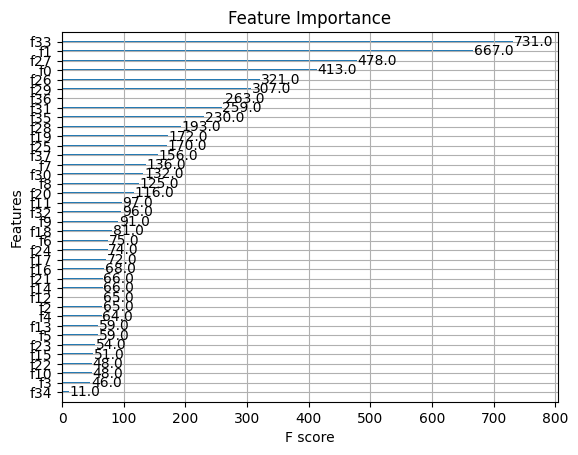

Cross-validation scores: {'accuracy': array([0.71159582, 0.75139554, 0.7898751 , 0.78859803, 0.7901609 ]), 'precision': array([0.73548554, 0.75221293, 0.76159095, 0.76159415, 0.76239906]), 'recall': array([0.66086912, 0.74977322, 0.84393846, 0.84021366, 0.84306094]), 'f1': array([0.69618371, 0.75099109, 0.8006529 , 0.79897451, 0.80070368])}
Mean cross-validation scores: {'accuracy': 0.7663250771749733, 'precision': 0.7546565267429906, 'recall': 0.7875710790299113, 'f1': 0.7695011806794992}
XGBoost Accuracy: 0.7309165273690618
XGBoost Precision: 0.4606727677467227
XGBoost Recall: 0.6951234987198531
XGBoost F1 Score: 0.5541192256313984
XGBoost ROC-AUC: 0.7962220977646116
XGBoost Confusion Matrix:
[[313967 109025]
 [ 40844  93125]]


In [ ]:
# 데이터 분할 (샘플링)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 최적의 하이퍼파라미터 설정
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 100,
    'subsample': 1.0,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# class_weight 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_smote), y=y_train_smote)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 최적의 하이퍼파라미터로 모델 재훈련
best_model_xgb = xgb.XGBClassifier(**best_params, scale_pos_weight=class_weights_dict[1])
best_model_xgb.fit(X_train_smote, y_train_smote)

# 예측
y_pred_xgb = best_model_xgb.predict(X_test)
y_pred_proba_xgb = best_model_xgb.predict_proba(X_test)[:, 1]

# 평가
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# 특징 중요도 시각화
xgb.plot_importance(best_model_xgb)
plt.title("Feature Importance")
plt.show()

# 교차 검증을 통한 모델 평가
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_results = {score: cross_val_score(best_model_xgb, X_train_smote, y_train_smote, cv=StratifiedKFold(5), scoring=score) for score in scoring}

# 결과 출력
print(f"Cross-validation scores: {cv_results}")
print(f"Mean cross-validation scores: { {score: cv_results[score].mean() for score in scoring} }")

print(f"XGBoost Accuracy: {accuracy_xgb}")
print(f"XGBoost Precision: {precision_xgb}")
print(f"XGBoost Recall: {recall_xgb}")
print(f"XGBoost F1 Score: {f1_xgb}")
print(f"XGBoost ROC-AUC: {roc_auc_xgb}")
print("XGBoost Confusion Matrix:")
print(cm_xgb)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.3 MB/s eta 0:00:00


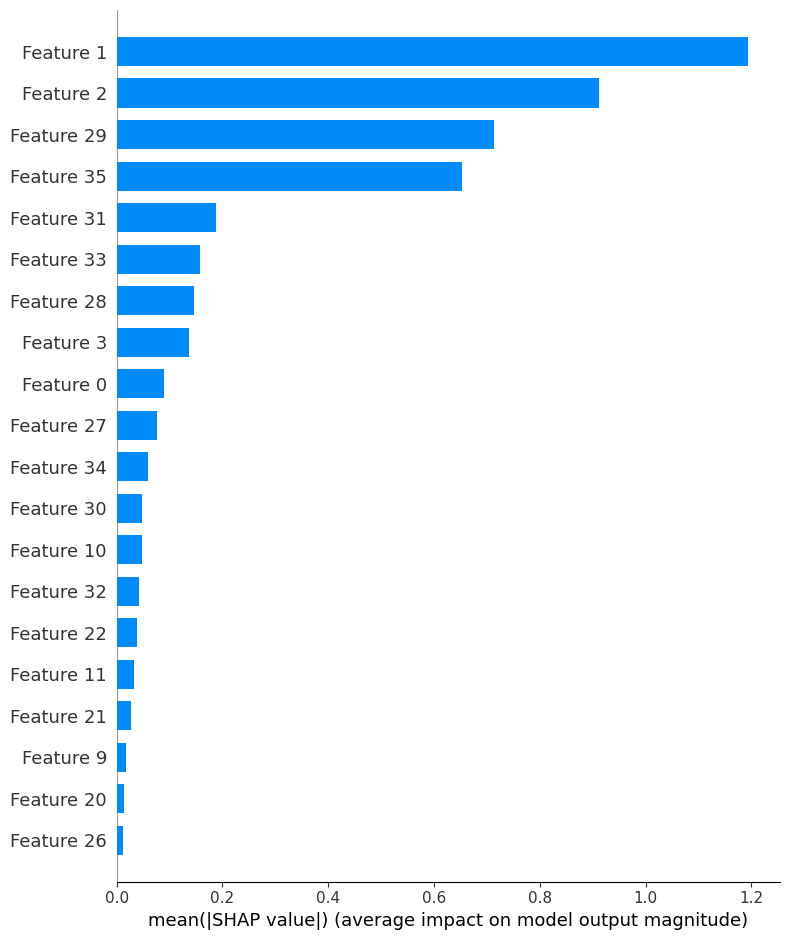

In [ ]:
import shap

# SHAP 값 계산
explainer = shap.TreeExplainer(best_model_xgb)
shap_values = explainer.shap_values(X_test)

# SHAP 요약 플롯
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
# X_test가 numpy 배열인 경우, SHAP 값을 DataFrame으로 변환
if isinstance(X_test, pd.DataFrame):
    columns = X_test.columns
else:
    columns = [f"feature_{i}" for i in range(X_test.shape[1])]

shap_values_df = pd.DataFrame(shap_values, columns=columns)

# 특성별 평균 절대 SHAP 값 계산
mean_abs_shap_values = shap_values_df.abs().mean().sort_values(ascending=False)

# SHAP 요약 결과를 표로 변환
shap_summary_df = pd.DataFrame(mean_abs_shap_values, columns=['mean_abs_shap_value'])

# 매칭된 feature 이름 추가
feature_mapping = {
    'feature_0': 'volume_at_start',
    'feature_1': 'highest_volume',
    'feature_2': 'lowest_change',
    'feature_3': 'lowest_volume',
    'feature_4': 'start_indicator_RSI_10',
    'feature_5': 'start_indicator_RSI_20',
    'feature_6': 'start_indicator_RSI_30',
    'feature_7': 'start_indicator_RSI_40',
    'feature_8': 'start_indicator_RSI_50',
    'feature_9': 'start_indicator_RSI_60',
    'feature_10': 'start_indicator_MACD_Line',
    'feature_11': 'start_indicator_MACD_Signal',
    'feature_12': 'start_indicator_MACD_Histogram',
    'feature_13': 'start_indicator_CCI_5',
    'feature_14': 'start_indicator_CCI_10',
    'feature_15': 'start_indicator_CCI_20',
    'feature_16': 'start_indicator_MFI_10',
    'feature_17': 'start_indicator_MFI_20',
    'feature_18': 'start_indicator_MFI_30',
    'feature_19': 'start_indicator_MFI_40',
    'feature_20': 'start_indicator_MFI_50',
    'feature_21': 'start_indicator_MFI_60',
    'feature_22': 'start_indicator_Volume_Ratio_10',
    'feature_23': 'start_indicator_Volume_Ratio_20',
    'feature_24': 'start_indicator_Volume_Ratio_30',
    'feature_25': 'start_indicator_Volume_Ratio_40',
    'feature_26': 'start_indicator_Volume_Ratio_50',
    'feature_27': 'start_indicator_Volume_Ratio_60',
    'feature_28': 'start_indicator_TR',
    'feature_29': 'start_indicator_ATR',
    'feature_30': 'start_indicator_Basic_Upper_Band',
    'feature_31': 'start_indicator_Basic_Lower_Band',
    'feature_32': 'start_indicator_Final_Upper_Band',
    'feature_33': 'start_indicator_Final_Lower_Band',
    'feature_34': 'start_indicator_SuperTrend',
    'feature_35': 'start_indicator_VWAP',
    'feature_36': 'start_indicator_INDICATOR',
    'feature_37': 'start_indicator_high_ind',
    'feature_38': 'start_indicator_low_ind',
    'feature_39': 'start_indicator_diff'
}

shap_summary_df['feature_name'] = shap_summary_df.index.map(feature_mapping)

# 컬럼 순서 재배열
shap_summary_df = shap_summary_df[['feature_name', 'mean_abs_shap_value']]

shap_summary_df

,feature_name,mean_abs_shap_value
feature_1,highest_volume,1.194548
feature_2,lowest_change,0.911177
feature_29,start_indicator_ATR,0.713983
feature_35,start_indicator_VWAP,0.653145
feature_31,start_indicator_Basic_Lower_Band,0.187988
feature_33,start_indicator_Final_Lower_Band,0.157249
feature_28,start_indicator_TR,0.146182
feature_3,lowest_volume,0.137251
feature_0,volume_at_start,0.090062
feature_27,start_indicator_Volume_Ratio_60,0.076730


from matplotlib import pyplot as plt
shap_summary_df['mean_abs_shap_value'].plot(kind='hist', bins=20, title='mean_abs_shap_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
shap_summary_df['mean_abs_shap_value'].plot(kind='line', figsize=(8, 4), title='mean_abs_shap_value')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from sklearn.feature_selection import RFE

# RFE 초기화
model = LogisticRegression(max_iter=500, solver='saga')
selector = RFE(model, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

# 선택된 특징
selected_features = X_train.columns[selector.support_]

print("Selected Features: ", selected_features)

In [ ]:
# 저장할 파일 경로 설정
file_path_xgb = '/content/drive/MyDrive/Data/SOL60_best_model_xgb.json'

# 모델 저장
best_model_xgb.save_model(file_path_xgb)

In [ ]:
#LightGBM

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'max_depth': [6, 8, 10, -1],
    'num_leaves': [31, 64, 127],
    'min_child_weight': [1, 5, 10],
    'min_split_gain': [0, 0.01, 0.02],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(), param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

In [ ]:
# 데이터 분할 (샘플링)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)

# 최적의 하이퍼파라미터 설정
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 100,
    'subsample': 1.0,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# 최적의 하이퍼파라미터로 모델 재훈련
best_model_lgb = best_params
best_model_lgb.fit(X_train, y_train)

# 예측
y_pred_lgb = best_model_lgb.predict(X_test)

# 평가
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb)
recall_lgb = recall_score(y_test, y_pred_lgb)
cm_lgb = confusion_matrix(y_test, y_pred_lgb)

# 교차 검증을 통한 모델 평가
cv_scores = cross_val_score(best_model_lgb, X_train, y_train, cv=5, scoring='accuracy')

# 결과 출력
results = {
    "Best Parameters": best_params,
    "Accuracy": accuracy_lgb,
    "Precision": precision_lgb,
    "Recall": recall_lgb,
    "Confusion Matrix": cm_lgb,
    "Cross-validation scores": cv_scores,
    "Mean cross-validation score": cv_scores.mean()
}

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


KeyboardInterrupt: 

In [ ]:
# CatBoost 모델 훈련 => 사용 불가
model_cat = CatBoostClassifier(max_depth=6, n_estimators=100, learning_rate=0.1, verbose=0)
model_cat.fit(X_train, y_train)

# 예측
y_pred_cat = model_cat.predict(X_test)

# 평가
accuracy_cat = accuracy_score(y_test, y_pred_cat)
precision_cat = precision_score(y_test, y_pred_cat)
recall_cat = recall_score(y_test, y_pred_cat)
cm_cat = confusion_matrix(y_test, y_pred_cat)

# 결과 출력
print(f"CatBoost Accuracy: {accuracy_cat}")
print(f"CatBoost Precision: {precision_cat}")
print(f"CatBoost Recall: {recall_cat}")
print("CatBoost Confusion Matrix:")
print(cm_cat)

In [ ]:
# 모델 저장
model_path = "/content/drive/MyDrive/Data/SOL60best_model_lgb.txt"
best_model_lgb.booster_.save_model(model_path)

In [ ]:
# 모델 불러오기
loaded_booster = lgb.Booster(model_file="/content/drive/MyDrive/Data/SOL60best_model_lgb.txt")

# Booster 객체를 LGBMClassifier 객체로 변환
best_model_lgb = lgb.LGBMClassifier()
best_model_lgb._Booster = loaded_booster

In [ ]:
# 기본 모델 설정 (Logistic Regression 제거)
estimators = [
    ('xgb', best_model_xgb),
    ('lgb', model_lgb)
]

# 스태킹 앙상블 모델 설정
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# 모델 훈련
stacking_model.fit(X_train, y_train)

# 예측
y_pred_stacking = stacking_model.predict(X_test)

# 평가
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
precision_stacking = precision_score(y_test, y_pred_stacking)
recall_stacking = recall_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)
roc_auc_stacking = roc_auc_score(y_test, stacking_model.predict_proba(X_test)[:, 1])
cm_stacking = confusion_matrix(y_test, y_pred_stacking)

# 결과 출력
print(f"Stacking Ensemble Accuracy: {accuracy_stacking}")
print(f"Stacking Ensemble Precision: {precision_stacking}")
print(f"Stacking Ensemble Recall: {recall_stacking}")
print(f"Stacking Ensemble F1 Score: {f1_stacking}")
print(f"Stacking Ensemble ROC-AUC: {roc_auc_stacking}")
print("Stacking Ensemble Confusion Matrix:")
print(cm_stacking)